Connected to Python 3.11.11

# Library

In [7]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform
import time
import pandas as pd

# Configuration

In [8]:
# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAMES = [
    "meta-llama/Llama-3.2-1B-Instruct",
    "allenai/OLMo-2-0425-1B",
    "Qwen/Qwen2.5-0.5B"
]
# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Verbose output settings
# If True, will print each question, model's answer, and correctness
PRINT_QUESTIONS = False  # Set to True to see detailed output for each question

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = 4  # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy", 
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # # "college_computer_science", "college_mathematics", "college_medicine",
    #  "college_physics", "computer_security", "conceptual_physics",
     "econometrics", "electrical_engineering", "elementary_mathematics",
    "formal_logic", "global_facts", "high_school_biology",
    "high_school_chemistry", "high_school_computer_science",
    # # "high_school_european_history", "high_school_geography",
    # # "high_school_government_and_politics", "high_school_macroeconomics",
    #  "high_school_mathematics", "high_school_microeconomics",
    #  "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"]
]

# UDF

In [9]:
def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"


def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("âœ“ Running in Google Colab")
        in_colab = True
    except:
        print("âœ“ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"âœ“ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"âœ“ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"âœ“ GPU Available: {gpu_name}")
        print(f"âœ“ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("âœ“ Apple Metal (MPS) Available")
        print("âœ“ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("âš ï¸  No GPU detected - running on CPU")
       
    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"âœ“ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"âŒ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"âŒ Apple METAL is incompatible with quantization")
            print("âœ“ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("âœ“ Quantization disabled - loading full precision model")
    
    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("âœ“ Hugging Face authenticated")
        else:
            print("âš ï¸  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("âš ï¸  Could not check Hugging Face authentication")
    
    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    # Note: model_name will be passed separately, not printed here
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~5 GB (FP32)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device

In [10]:
def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None
    
    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")
    
    return config


def load_model_and_tokenizer(model_name, device):
    """Load model with optional quantization"""
    print(f"\nLoading model {model_name}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("âœ“ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    dtype=torch.float32,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("âœ“ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer
        
    except Exception as e:
        print(f"\nâŒ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt

def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question.
    Returns:
        answer (str): 'A'/'B'/'C'/'D'
        gpu_compute_s (float|None): CUDA time spent inside model.generate for this sample
    """
    device = model.device
    use_cuda_timing = (device.type == "cuda") and torch.cuda.is_available()

    # CPU work (NOT counted in GPU compute time)
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}

    gpu_compute_s = None

    # --- GPU compute timed region: ONLY generate() ---
    if use_cuda_timing:
        # Make sure prior kernels are done so timing isn't polluted
        torch.cuda.synchronize()
        start_evt = torch.cuda.Event(enable_timing=True)
        end_evt = torch.cuda.Event(enable_timing=True)

        start_evt.record()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    if use_cuda_timing:
        end_evt.record()
        torch.cuda.synchronize()
        gpu_compute_s = start_evt.elapsed_time(end_evt) / 1000.0  # ms -> s

    # CPU-ish work (NOT counted)
    # Make decode explicit on CPU to avoid hidden sync surprises
    new_tokens = outputs[0, inputs["input_ids"].shape[1]:].detach().cpu()
    generated_text = tokenizer.decode(new_tokens, skip_special_tokens=True)

    answer = generated_text.strip()[:1].upper()
    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer, gpu_compute_s



# from datasets import load_dataset
# from tqdm import tqdm

def evaluate_subject(model, tokenizer, subject, print_examples=False):
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"❌ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0
    question_details = []

    gpu_compute_total_s = 0.0
    gpu_compute_count = 0  # number of questions where we successfully measured GPU time

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)

        predicted_answer, gpu_s = get_model_prediction(model, tokenizer, prompt)

        if gpu_s is not None:
            gpu_compute_total_s += gpu_s
            gpu_compute_count += 1

        is_correct = predicted_answer == correct_answer

        question_details.append({
            "question": question,
            "choices": choices,
            "choice_a": choices[0] if len(choices) > 0 else "",
            "choice_b": choices[1] if len(choices) > 1 else "",
            "choice_c": choices[2] if len(choices) > 2 else "",
            "choice_d": choices[3] if len(choices) > 3 else "",
            "predicted_answer": predicted_answer,
            "correct_answer": correct_answer,
            "is_correct": is_correct,
            "gpu_compute_s": gpu_s,  # optional per-question GPU compute
        })

        if print_examples:
            print("="*40)
            print("Q:", question)
            for label, choice in zip(["A", "B", "C", "D"], choices):
                print(f"  {label}. {choice}")
            print(f"→ Model answer: {predicted_answer} (Correct: {correct_answer})")
            print("Result:", "RIGHT ✓" if is_correct else "WRONG ✗")

        if is_correct:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"✓ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy,
        "question_details": question_details,
        "gpu_compute_total_s": gpu_compute_total_s,
        # "gpu_compute_count": gpu_compute_count,
        # "gpu_compute_avg_s": (gpu_compute_total_s / gpu_compute_count) if gpu_compute_count > 0 else None,
    }


Connected to agentic_env (Python 3.10.19)

In [11]:
def main(model_name):
    """Main evaluation function for a single model (GPU compute removed)"""
    print("\n" + "="*70)
    print(f"{model_name} MMLU Evaluation:")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(model_name, device)
    
    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0
    all_question_data = []  # Collect all question-level data for dataframe
    
    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")
    
    # Initialize timing
    start_real_time = time.perf_counter()
    start_cpu_time = time.process_time()
    
    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject, print_examples=PRINT_QUESTIONS)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]
            
            # Collect question details with model and subject info
            if "question_details" in result:
                for q_detail in result["question_details"]:
                    all_question_data.append({
                        "model": model_name,
                        "subject": subject,
                        "question": q_detail["question"],
                        "choice_a": q_detail["choice_a"],
                        "choice_b": q_detail["choice_b"],
                        "choice_c": q_detail["choice_c"],
                        "choice_d": q_detail["choice_d"],
                        "predicted_answer": q_detail["predicted_answer"],
                        "correct_answer": q_detail["correct_answer"],
                        "is_correct": q_detail["is_correct"]
                    })
    
    # Calculate timing
    end_real_time = time.perf_counter()
    end_cpu_time = time.process_time()
    
    real_time_seconds = end_real_time - start_real_time
    cpu_time_seconds = end_cpu_time - start_cpu_time
    
    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0
    
    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {model_name}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print("\n" + "-"*70)
    print("TIMING INFORMATION")
    print("-"*70)
    print(f"Real Time: {real_time_seconds:.2f} seconds ({real_time_seconds/60:.2f} minutes)")
    print(f"CPU Time: {cpu_time_seconds:.2f} seconds ({cpu_time_seconds/60:.2f} minutes)")
    print(f"GPU Time: {result['gpu_compute_total_s']:.2f} seconds")
    print("="*70)
    
    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    # Sanitize model name for filename
    model_name_safe = model_name.replace("/", "_").replace("\\", "_")
    output_file = f"{model_name_safe}_mmlu_results{quant_suffix}_{timestamp}.json"
    
    output_data = {
        "model": model_name,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "timing": {
            "real_time_seconds": real_time_seconds,
            "cpu_time_seconds": cpu_time_seconds,
            "gpu_time_seconds": result['gpu_compute_total_s'],
        },
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }
    
    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)
    
    print(f"\n✓ Results saved to: {output_file}")
    
    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)
        
        print("\n📚 Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")
        
        print("\n📉 Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")
    
    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("💾 To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")
    
    print("\n✅ Evaluation complete!")
    
    # Create and save dataframe with all question details
    df = None
    csv_file = None
    if all_question_data:
        df = pd.DataFrame(all_question_data)
        csv_file = f"{model_name_safe}_mmlu_questions{quant_suffix}_{timestamp}.csv"
        df.to_csv(csv_file, index=False)
        print(f"✓ Question details saved to: {csv_file}")
        print(f"   Total questions in dataframe: {len(df)}")
    
    return output_file, df, csv_file



In [ ]:
def evaluate_all_models():
    """Evaluate all models in MODEL_NAMES list"""
    print("\n" + "="*70)
    print("MULTI-MODEL EVALUATION")
    print("="*70)
    print(f"Evaluating {len(MODEL_NAMES)} models:")
    for i, model_name in enumerate(MODEL_NAMES, 1):
        print(f"  {i}. {model_name}")
    print("="*70 + "\n")
    
    all_output_files = []
    all_results = []
    all_dataframes = []  # Collect dataframes from all models
    
    for i, model_name in enumerate(MODEL_NAMES, 1):
        print("\n" + "="*70)
        print(f"MODEL {i}/{len(MODEL_NAMES)}: {model_name}")
        print("="*70)
        
        try:
            output_file, df, csv_file = main(model_name)
            all_output_files.append(output_file)
            all_results.append({
                "model": model_name,
                "output_file": output_file,
                "csv_file": csv_file,
                "status": "success"
            })
            if df is not None and len(df) > 0:
                all_dataframes.append(df)
        except Exception as e:
            print(f"\n❌ Error evaluating {model_name}: {e}")
            all_results.append({
                "model": model_name,
                "status": "error",
                "error": str(e)
            })
            import traceback
            traceback.print_exc()
    
    # Combine all dataframes into one
    combined_df = None
    combined_csv_file = None
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        combined_csv_file = f"all_models_mmlu_questions_{timestamp}.csv"
        combined_df.to_csv(combined_csv_file, index=False)
        print("\n" + "="*70)
        print("COMBINED DATAFRAME CREATED")
        print("="*70)
        print(f"Combined CSV file: {combined_csv_file}")
        print(f"Total questions across all models: {len(combined_df)}")
        print(f"Models included: {combined_df['model'].unique().tolist()}")
        print(f"Subjects included: {len(combined_df['subject'].unique())}")
        print("="*70)
    
    # Print final summary
    print("\n" + "="*70)
    print("FINAL SUMMARY - ALL MODELS")
    print("="*70)
    print(f"Total models evaluated: {len(MODEL_NAMES)}")
    successful = sum(1 for r in all_results if r["status"] == "success")
    print(f"Successful: {successful}")
    print(f"Failed: {len(all_results) - successful}")
    print("\nResults files:")
    for result in all_results:
        if result["status"] == "success":
            print(f"  ✓ {result['model']}: {result['output_file']}")
            if result.get('csv_file'):
                print(f"    CSV: {result['csv_file']}")
        else:
            print(f"  ❌ {result['model']}: FAILED - {result.get('error', 'Unknown error')}")
    if combined_csv_file:
        print(f"\n  📊 Combined dataframe: {combined_csv_file}")
    print("="*70)
    
    return all_output_files, all_results, combined_df, combined_csv_file


if __name__ == "__main__":
    try:
        # Evaluate all models in MODEL_NAMES
        output_files, results, combined_df, combined_csv_file = evaluate_all_models()
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

## Step 5: Modify the code to do the following:

In [13]:
### Run on a selection of 10 subjects using 2 other small models in addtion to Llama 3.2-1B.  
### Add timing information to the evaluation summary showing the cycles consumed by each model.  Include all of real time, CPU time, and GPU time.
### Add an option to the program to make it print out each question, the answer the model gives, and whether the answer is right or wrong. 

# Step 6: Plot the results

In [15]:
import pandas as pd

# Read the specified CSV file
csv_file_path = r"C:\Users\arifu\Desktop\Agentic_Class26\Topic 1\all_models_mmlu_questions_20260115_185953.csv"
df = pd.read_csv(csv_file_path)

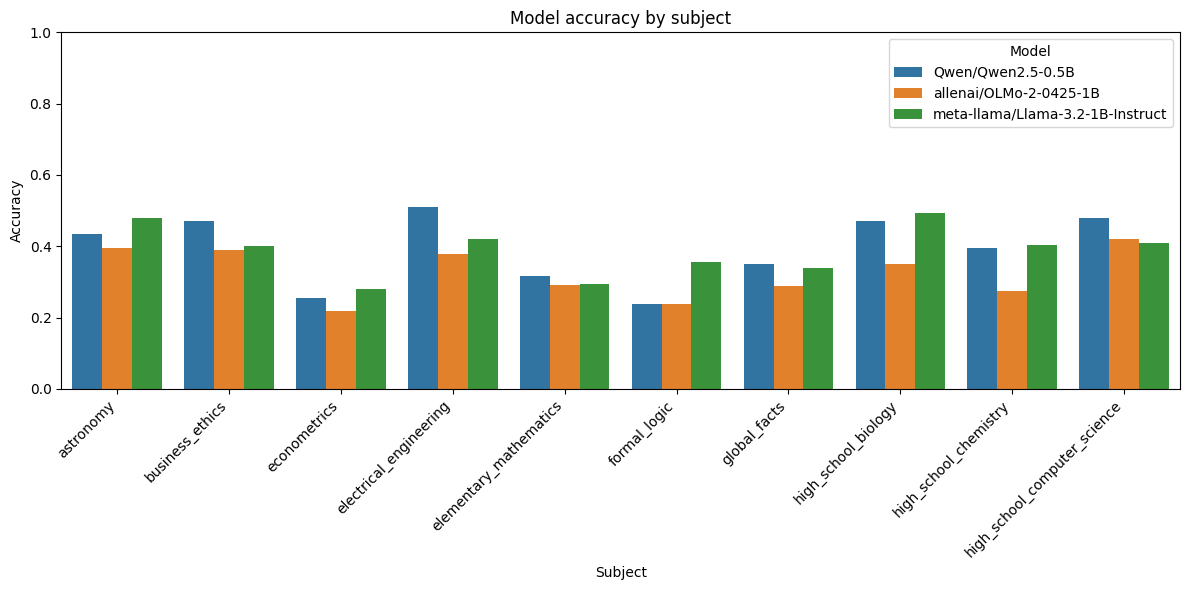

In [29]:
# # Count how many questions per subject in df
# questions_per_subject = df.groupby('subject')['question'].nunique()
# print(questions_per_subject)
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy per subject for each model
accuracy_df = (
    df.groupby(['subject', 'model'])['is_correct']
    .mean()
    .reset_index()
    .rename(columns={'is_correct': 'accuracy'})
)

plt.figure(figsize=(12, 6))
sns.barplot(data=accuracy_df, x='subject', y='accuracy', hue='model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title('Model accuracy by subject')
plt.ylabel('Accuracy')
plt.xlabel('Subject')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# More or less, all models struggle with the same subject. For example, econometrics, elementary_mathematics, formal logic, etc.

Unique model_clean entries: {'meta-llama/llama-3.2-1b-instruct', 'qwen/qwen2.5-0.5b', 'allenai/olmo-2-0425-1b'}


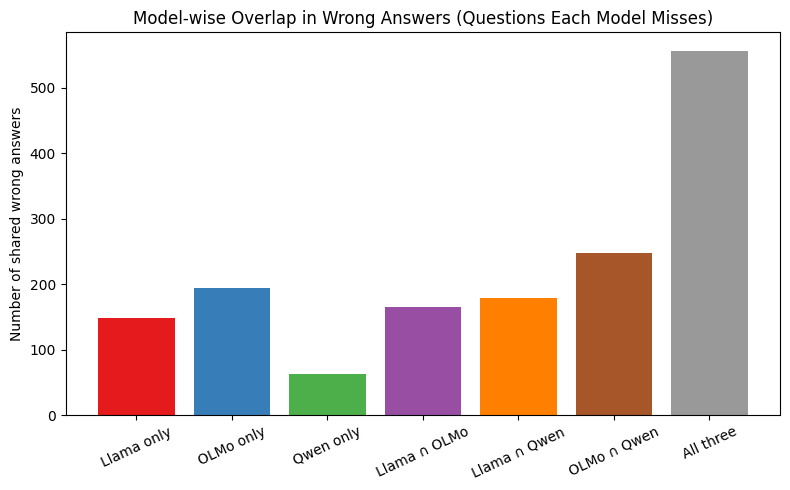

Overlap details:
Llama only     : 149
OLMo only      : 194
Qwen only      : 62
Llama ∩ OLMo   : 165
Llama ∩ Qwen   : 179
OLMo ∩ Qwen    : 248
All three      : 557


In [39]:
# ---- Compute sets of wrong question IDs for each model ----

# 1. Harmonize model names for robust mapping.
# We'll use the cleaned model names in the 'model_clean' column. Let's inspect which unique entries exist:
unique_clean_models = set(df['model_clean'])
print("Unique model_clean entries:", unique_clean_models)

# 2. Map canonical names to their cleaned lowercase format (from your sample)
# Sample values from your table: 'meta-llama/llama-3.2-1b-instruct', 'allenai/olmo-2-0425-1b', 'qwen/qwen2.5-0.5b'
canonical_models = {
    'Llama':   'meta-llama/llama-3.2-1b-instruct',
    'OLMo':    'allenai/olmo-2-0425-1b',
    'Qwen':    'qwen/qwen2.5-0.5b',
}

# 3. For each canonical model, collect the set of questions it got wrong.
model_wrongs = {}
for short, canonical in canonical_models.items():
    # Use lowercase and strip for robust comparison
    wrong_qs = set(df[(df['model_clean'] == canonical) & (df['is_correct'] == False)]['question'])
    model_wrongs[short] = wrong_qs

# 4. Calculate overlaps
llama_wrong = model_wrongs['Llama']
olmo_wrong  = model_wrongs['OLMo']
qwen_wrong  = model_wrongs['Qwen']

llama_olmo = llama_wrong & olmo_wrong
llama_qwen = llama_wrong & qwen_wrong
olmo_qwen  = olmo_wrong  & qwen_wrong
all_three  = llama_wrong & olmo_wrong & qwen_wrong

# Compute exclusive and overlap counts
overlap_counts = {
    'Llama only': len(llama_wrong - olmo_wrong - qwen_wrong),
    'OLMo only': len(olmo_wrong - llama_wrong - qwen_wrong),
    'Qwen only': len(qwen_wrong - llama_wrong - olmo_wrong),
    'Llama ∩ OLMo': len((llama_olmo - all_three)),
    'Llama ∩ Qwen': len((llama_qwen - all_three)),
    'OLMo ∩ Qwen': len((olmo_qwen - all_three)),
    'All three': len(all_three),
}

# ---- Bar Chart of Overlaps ----
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
colors = [
    '#e41a1c', '#377eb8', '#4daf4a',  # single
    '#984ea3', '#ff7f00', '#a65628',  # pairwise
    '#999999',                        # all three
]
ax.bar(overlap_counts.keys(), overlap_counts.values(), color=colors)
ax.set_ylabel("Number of shared wrong answers")
ax.set_title("Model-wise Overlap in Wrong Answers (Questions Each Model Misses)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# ---- Print for interpretation ----
print("Overlap details:")
for k, v in overlap_counts.items():
    print(f"{k:15s}: {v}")


Overlap details:
Llama only     : 149
OLMo only      : 194
Qwen only      : 62
Llama ∩ OLMo   : 165
Llama ∩ Qwen   : 179
OLMo ∩ Qwen    : 248
All three      : 557

After running the code and analyzing the overlap of incorrect answers across models, the mistakes do not appear random. A large number of questions are missed by all three models, indicating the presence of inherently difficult or ambiguous questions that consistently challenge small language models. These shared errors suggest systematic limitations in reasoning rather than isolated failures.

Pairwise overlaps further indicate that some errors are correlated between models, while the third model (Qwen) occasionally succeeds.

Overall, while not all models make mistakes on the exact same questions, there is significant overlap in their errors. This demonstrates that model failures are structured and subject-dependent rather than random.